<a href="https://colab.research.google.com/github/remre/StriveSchool-ai/blob/main/w6_deepl/benchmarkproject/ChineseMnistCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn

import cv2
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as a_s
import os 
from torchsummary import summary
import zipfile

In [ ]:
#get kaggle.json 

os.environ["KAGGLE_CONFIG_DIR"] = ("/content")

In [ ]:
#than download the dataset
!kaggle datasets download -d gpreda/chinese-mnist

In [ ]:
#unzip the dataset

with zipfile.ZipFile('/content/chinese-mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
#crate the dataframe
df = pd.read_csv('chinese_mnist.csv',sep=',')

In [ ]:
#y = df['character']

In [ ]:
X = df.drop('character', axis=1)

In [ ]:
#take a look at it
df# image file names include some info about the image like suite_id sample id and code.
#if we can add value as a label for our custom dataset that will be good.

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [ ]:
df.isnull().sum(),df.shape #there is no missing vals and number of data and number of images are match up

(suite_id     0
 sample_id    0
 code         0
 value        0
 character    0
 dtype: int64, (15000, 5))

In [ ]:
df.info()#we need to encode df character. we can use get dummies 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


In [ ]:
X = df.drop('character', axis=1)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, k,l, csv_file ='chinese_mnist.csv'):


    self.df = pd.read_csv(csv_file)
    

    self.k= {'九':int(9),'十':int(10),'百':int(11),'千':int(12),'万':int(13),'亿':int(14),'零':int(0),'一':int(1),'二':int(2),'三':int(3),'四':int(4),'五':int(5),'六':int(6),'七':int(7),'八':int(8)}

    


    self.target = 'character'
    self.features = ['suite_id','sample_id','code',]

    #self.categorical = 'value'

    #self.cat = pd.get_dummies(df, prefix=self.categorical)

    self.labels   = np.asarray(self.df.iloc[:, 4])
    
    self.y = df[self.target]
    self.X = df.drop(self.target, axis =1 )

  def __getitem__(self,idx):

    single_image_label = self.labels[idx]

    class_id = self.k[single_image_label]
    
    img = Image.open(f"/content/data/data/input_{self.X.iloc[idx, 0]}_{self.X.iloc[idx, 1]}_{self.X.iloc[idx, 2]}.jpg")
    img = np.array(img) # convert to np.array
       

    return img, class_id

  def __len__(self):

    return len(self.X)



In [ ]:
train_df = df.groupby('value').apply(lambda x: x.sample(700, random_state=42)).reset_index(drop=True)
x_train, y_train  = train_df.iloc[:, :-2], train_df.iloc[:, -2]

test_df  = df.groupby('value').apply(lambda x: x.sample(300, random_state=42)).reset_index(drop=True)
x_test, y_test    = test_df.iloc[:, :-2], test_df.iloc[:, -2]

In [ ]:
#create train dataset and test dataset 
train_ds = CustomDataset(x_train, y_train)
trainloader = DataLoader(dataset=train_ds,batch_size=32, shuffle=True)

In [ ]:
test_ds = CustomDataset(x_test, y_test)
testloader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [ ]:
dictt = {int(9):'九',int(10):'十',int(11):'百',
  int(12):'千',int(13):'万',int(14):'亿',
  int(0):'零',int(1):'一',int(2):'二',
  int(3):'三',int(4):'四',int(5):'五',
  int(6):'六',int(7):'七',int(8):'八'}

'八'

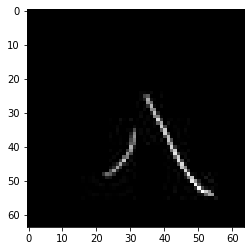

In [ ]:
dataiter = iter(testloader)
images,labels = dataiter.next()
plt.imshow(images[0], cmap='gray')#
dictt[int(labels[0])]

In [ ]:
#images[0].shape

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        
        self.fc1 = nn.Linear(64*13*13, 500)
        self.fc2 = nn.Linear(500, 15)

        self.log_softmax = nn.LogSoftmax(dim=0)
        self.conv2_drop = nn.Dropout2d()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        output = self.log_softmax(x)
        return output

model = Net()
            

In [ ]:
#summary(model,(64,64))

In [ ]:
los = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001,)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
#optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum=1)

In [ ]:
epochs = 5
#learning_rate = 0.001
#decay_rate = learning_rate / epochs
#optimizer = optim.Adagrad(model.parameters(),lr = learning_rate)
print_every = 96

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # turn it to float and resize
        
        images = images.resize_(images.size()[0], 64,64).float()
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        losss = los(output, labels)     # 2) Compute loss
        losss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += losss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/len(trainloader):.3f}")
            running_loss = 0

Epoch: 1/5
	Iteration: 0	 Loss: 0.008
	Iteration: 184	 Loss: 0.684
	Iteration: 368	 Loss: 0.379
Epoch: 2/5
	Iteration: 0	 Loss: 0.001
	Iteration: 184	 Loss: 0.226
	Iteration: 368	 Loss: 0.208
Epoch: 3/5
	Iteration: 0	 Loss: 0.001
	Iteration: 184	 Loss: 0.160
	Iteration: 368	 Loss: 0.162
Epoch: 4/5
	Iteration: 0	 Loss: 0.001
	Iteration: 184	 Loss: 0.129
	Iteration: 368	 Loss: 0.133
Epoch: 5/5
	Iteration: 0	 Loss: 0.001
	Iteration: 184	 Loss: 0.126
	Iteration: 368	 Loss: 0.119


In [ ]:
test_size = len(test_ds)
train_size = len(train_ds)
r_labels = np.array([])
preds  = np.array([])

correct_preds = np.array([])


for i, (images, labels) in enumerate(iter(testloader)):
  model.eval()

  # turn it to float and resize
    
  images = images.resize_(images.size()[0], 64,64).float()

  outputs = model(images)

  loss = los(outputs, labels)



  r_labels = np.concatenate((r_labels, labels.numpy()))


  for index, item in enumerate(outputs):
      if r_labels[index] == torch.argmax(item):
          correct_preds += 1

      preds  = np.concatenate((preds, torch.argmax(item).unsqueeze(-1).detach().numpy()))


conf_mat = confusion_matrix(r_labels, preds)


accuracy_scores= a_s(r_labels, preds)

print(f'Test results with respect to confusion matrix: \n{conf_mat} \nand the accuracy score is : \n {accuracy_scores}')
# it 92% so far


Test results with respect to confusion matrix: 
[[982   1   0   2   1   1   0   1   0   1   1   2   4   3   1]
 [  0 986   6   0   2   0   2   0   1   0   1   0   0   2   0]
 [  1  17 952  21   0   4   1   0   1   0   0   0   2   0   1]
 [  3   5 154 822   0   3   4   1   2   0   0   1   3   0   2]
 [  3   1   1   0 955   4   1   2   2   4   2  23   0   0   2]
 [  1   2   5  28   1 953   0   0   1   2   1   4   1   1   0]
 [  8   2   4   8   1   2 942   1   6   9   6   1   4   5   1]
 [  6   1   1   1   1   3   2 954   3  17   4   1   4   0   2]
 [  1   1   0   0   2   0   4   0 982   6   1   2   1   0   0]
 [  2   1   0   1   0   4   4  19   4 942   3   2   1   1  16]
 [  2   1   0   0   2   2   5   3   1   3 939   1  37   3   1]
 [  3   0   2   2  15  13   1   3   2   2   2 933   3  18   1]
 [  2   1   5   2   2   7   2   2   2   1  35   3 929   2   5]
 [  8   9   1   0   1   2  10   1   1   7   1  15   5 937   2]
 [  3   1   1   1   5   7   3   5  11  33   0   3   3   1 923]] 
and t

In [ ]:
dict = {'九':9,'十 ':10,'百':100,'千':1000,'万':10000,'亿':100000000,'零':0,'一':1,'二':2,'三':3,'四':4,'五':5,'六':6,'七':100,'八':8}

In [ ]:

for i,(images,labels) in enumerate(iter(testloader)):
    
  with torch.no_grad():

    images = images.resize_(images.size()[0], 64,64).float()
    output = model(images)



#dict[int(output[0])]
#it works

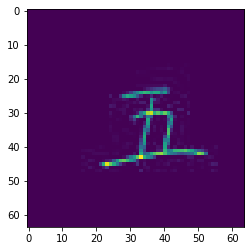

In [ ]:
plt.imshow(images[9,:,:])

In [ ]:
print(dict[output[9,:].argmax().item()])


五
